# UFC 승리예측

#### 모듈 불러오기

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#### 동시 출력 가능

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### 경고 메시지 제거

In [3]:
import warnings
warnings.filterwarnings(action="ignore")

#### 데이터 불러오기

In [4]:
data = pd.read_csv("data.csv")
blue = pd.read_csv("blue.csv")
red = pd.read_csv("red.csv")
player = pd.read_csv("player.csv")

#### player 데이터는 원 data에 R,B선수들을 밑으로 붙인것
#### 시계열 데이터분석에 한계를 갖고, 동일한 선수여도 시기가 다르면 다른 선수로 인식
#### 선수들의 성향을 클러스터링하기 위해 레드 블루를 쪼개어 rbind함.

#### 결측치 확인

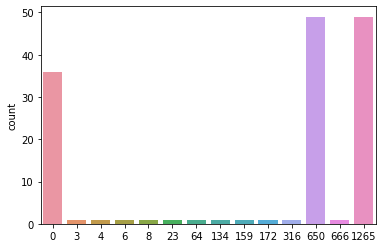

In [5]:
sns.countplot(data.isnull().sum(),data=data)

#### 결측치는 분석 상 비약을 초래할 것이라 판단하에 제거

#### UFC 특성상 체급별로 평균 혹은 중앙값을 채운 후 모델을 돌린다면 같은 스탯끼리 매치가 성사되어 드로우가 발생
#### 또한 0,1로 분류 시에도 부정확한 결괏값이라고 판단되기에 제거하였다.

In [6]:
data = data.dropna()
data.head()

,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,no_of_rounds,B_current_lose_streak,...,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,Henry Cejudo,Marlon Moraes,Marc Goddard,2019-06-08,"Chicago, Illinois, USA",Red,True,Bantamweight,5,0,...,2,0,0,8,Orthodox,162.56,162.56,135.0,31.0,32.0
1,Valentina Shevchenko,Jessica Eye,Robert Madrigal,2019-06-08,"Chicago, Illinois, USA",Red,True,Women's Flyweight,5,0,...,0,2,0,5,Southpaw,165.10,167.64,125.0,32.0,31.0
2,Tony Ferguson,Donald Cerrone,Dan Miragliotta,2019-06-08,"Chicago, Illinois, USA",Red,False,Lightweight,3,0,...,3,6,1,14,Orthodox,180.34,193.04,155.0,36.0,35.0
3,Jimmie Rivera,Petr Yan,Kevin MacDonald,2019-06-08,"Chicago, Illinois, USA",Blue,False,Bantamweight,3,0,...,1,0,0,6,Orthodox,162.56,172.72,135.0,26.0,29.0
4,Tai Tuivasa,Blagoy Ivanov,Dan Miragliotta,2019-06-08,"Chicago, Illinois, USA",Blue,False,Heavyweight,3,0,...,2,0,0,3,Southpaw,187.96,190.50,264.0,32.0,26.0


### Explore The number of Title match

In [7]:
data["weight_class"].value_counts()

Lightweight              644
Welterweight             636
Middleweight             474
Light Heavyweight        340
Featherweight            299
Heavyweight              264
Bantamweight             243
Flyweight                138
Women's Strawweight       74
Women's Bantamweight      58
Women's Flyweight         19
Catch Weight               9
Women's Featherweight      4
Name: weight_class, dtype: int64

In [8]:
Red = data["R_fighter"]
Blue = data["B_fighter"]

In [9]:
len(list(set(Red)-set(Blue)))

117

In [10]:
len(list(set(Blue)-set(Red)))

290

In [11]:
data["title_bout"].value_counts()

False    2988
True      214
Name: title_bout, dtype: int64

In [12]:
arr1 = data[data["title_bout"]==1]["weight_class"].value_counts()
title = pd.DataFrame(arr1)
title.rename(columns={"weight_class":"title"},inplace=True)

arr2 = data[data["title_bout"]==0]["weight_class"].value_counts()
untitle = pd.DataFrame(arr2)
untitle.rename(columns={"weight_class":"untitle"},inplace=True)

In [13]:
df= pd.merge(title,untitle,left_index=True,right_index=True)
df.head()

,title,untitle
Light Heavyweight,38,302
Welterweight,32,604
Heavyweight,29,235
Middleweight,26,448
Lightweight,26,618


In [14]:
titlematch = data[["weight_class","title_bout"]]
titlematch.head()

,weight_class,title_bout
0,Bantamweight,True
1,Women's Flyweight,True
2,Lightweight,False
3,Bantamweight,False
4,Heavyweight,False


In [15]:
ct = pd.crosstab(titlematch.weight_class,titlematch.title_bout)

### 체급별 타이틀 경기 수

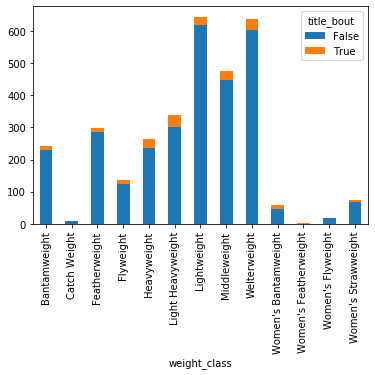

In [16]:
ct.plot.bar(stacked=True)
plt.legend(title='title_bout')
plt.show()

#### 유의미한 변수 선택

In [17]:
data_X = data[['B_avg_BODY_att', 'B_avg_CLINCH_att', 'B_avg_DISTANCE_att', 'B_avg_GROUND_att', 'B_avg_HEAD_att', 'B_avg_KD', 'B_avg_LEG_att',
       'B_avg_SIG_STR_att', 'B_avg_SUB_ATT', 'B_avg_TD_att', 'B_avg_TOTAL_STR_att', 'B_Height_cms', 'B_Reach_cms', 'B_Weight_lbs',
              'R_avg_BODY_att', 'R_avg_CLINCH_att', 'R_avg_DISTANCE_att', 'R_avg_GROUND_att', 'R_avg_HEAD_att', 'R_avg_KD', 'R_avg_LEG_att',
       'R_avg_SIG_STR_att', 'R_avg_SUB_ATT', 'R_avg_TD_att', 'R_avg_TOTAL_STR_att', 'R_Height_cms', 'R_Reach_cms', 'R_Weight_lbs',
              "weight_class", "title_bout","B_win_by_Decision_Majority","B_win_by_Decision_Split","B_win_by_Decision_Unanimous","B_win_by_KO/TKO",
"B_win_by_Submission","B_win_by_TKO_Doctor_Stoppage","R_win_by_Decision_Majority","R_win_by_Decision_Split","R_win_by_Decision_Unanimous","R_win_by_KO/TKO",
"R_win_by_Submission","R_win_by_TKO_Doctor_Stoppage",
              "B_current_lose_streak", "B_current_win_streak", "B_wins", "B_Stance",
              "R_current_lose_streak", "R_current_win_streak", "R_wins", "R_Stance",
              "B_age", "R_age",  "Winner"]]

In [18]:
data_X["Winner"].value_counts()

Red     2016
Blue    1135
Draw      51
Name: Winner, dtype: int64

#### 명목형 변수 수치형 변환

In [19]:
data_X["Winner"] = data_X["Winner"].map({"Red" : 1, "Blue" : 0, "Draw" : 100})

#### weight_class, stance는 각 체급별로 각 자세별로 
#### 다르므로, one_hot_encoding

In [20]:
a = pd.get_dummies(data_X["weight_class"], prefix = "weight_class")

In [21]:
b = pd.get_dummies(data_X["B_Stance"], prefix = "B_Stance")
c = pd.get_dummies(data_X["R_Stance"], prefix = "R_Stance")

In [22]:
onehot = pd.concat([a,b,c], axis = 1)

In [23]:
onehot.head()

,weight_class_Bantamweight,weight_class_Catch Weight,weight_class_Featherweight,weight_class_Flyweight,weight_class_Heavyweight,weight_class_Light Heavyweight,weight_class_Lightweight,weight_class_Middleweight,weight_class_Welterweight,weight_class_Women's Bantamweight,...,weight_class_Women's Flyweight,weight_class_Women's Strawweight,B_Stance_Open Stance,B_Stance_Orthodox,B_Stance_Southpaw,B_Stance_Switch,R_Stance_Open Stance,R_Stance_Orthodox,R_Stance_Southpaw,R_Stance_Switch
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [24]:
data_X = pd.concat([data_X, onehot], axis = 1)

In [25]:
data_X.head()

,B_avg_BODY_att,B_avg_CLINCH_att,B_avg_DISTANCE_att,B_avg_GROUND_att,B_avg_HEAD_att,B_avg_KD,B_avg_LEG_att,B_avg_SIG_STR_att,B_avg_SUB_ATT,B_avg_TD_att,...,weight_class_Women's Flyweight,weight_class_Women's Strawweight,B_Stance_Open Stance,B_Stance_Orthodox,B_Stance_Southpaw,B_Stance_Switch,R_Stance_Open Stance,R_Stance_Orthodox,R_Stance_Southpaw,R_Stance_Switch
0,9.200000,0.200000,62.600000,2.600000,48.600000,0.800000,7.6,65.40,0.400000,0.80000,...,0,0,0,1,0,0,0,1,0,0
1,14.600000,11.800000,124.700000,2.400000,112.000000,0.000000,12.3,138.90,0.700000,1.00000,...,1,0,0,1,0,0,0,0,1,0
2,15.354839,6.741935,84.741935,5.516129,67.645161,0.645161,14.0,97.00,0.354839,2.16129,...,0,0,0,1,0,0,0,1,0,0
3,17.000000,13.750000,109.500000,13.000000,116.250000,0.500000,3.0,136.25,0.250000,2.50000,...,0,0,0,0,0,1,0,1,0,0
4,17.000000,2.500000,201.000000,0.000000,184.500000,0.000000,2.0,203.50,0.000000,0.00000,...,0,0,0,0,1,0,0,0,1,0


#### 더미화 후 범주 컬럼 제거

In [26]:
data_X = data_X.drop(["weight_class", "B_Stance", "R_Stance"], axis = 1)

In [27]:
data_X["Winner"]

0       1
1       1
2       1
3       0
4       0
       ..
4887    1
4901    1
4923    1
4967    1
5008    1
Name: Winner, Length: 3202, dtype: int64

##### 선수 스탯 컬럼을 가지고 선수의 성향 타입 clustering
##### (복싱,권투) - (레슬링,주짓수) - (MMA)

In [28]:
from sklearn.cluster import KMeans
cluster = KMeans(n_clusters = 3)

In [29]:
x = player[['B_avg_BODY_att', 'B_avg_CLINCH_att', 'B_avg_DISTANCE_att', 'B_avg_GROUND_att', 'B_avg_HEAD_att', 'B_avg_KD', 'B_avg_LEG_att',
       'B_avg_SIG_STR_att', 'B_avg_SUB_ATT', 'B_avg_TD_att', 'B_avg_TOTAL_STR_att', 'B_win_by_KO/TKO', 'B_win_by_Submission',]]

In [30]:
x.head()

,B_avg_BODY_att,B_avg_CLINCH_att,B_avg_DISTANCE_att,B_avg_GROUND_att,B_avg_HEAD_att,B_avg_KD,B_avg_LEG_att,B_avg_SIG_STR_att,B_avg_SUB_ATT,B_avg_TD_att,B_avg_TOTAL_STR_att,B_win_by_KO/TKO,B_win_by_Submission
0,9.200000,0.200000,62.600000,2.600000,48.600000,0.800000,7.6,65.40,0.400000,0.80000,66.400000,2.0,1.0
1,14.600000,11.800000,124.700000,2.400000,112.000000,0.000000,12.3,138.90,0.700000,1.00000,158.700000,0.0,0.0
2,15.354839,6.741935,84.741935,5.516129,67.645161,0.645161,14.0,97.00,0.354839,2.16129,103.709677,10.0,6.0
3,17.000000,13.750000,109.500000,13.000000,116.250000,0.500000,3.0,136.25,0.250000,2.50000,154.750000,2.0,0.0
4,17.000000,2.500000,201.000000,0.000000,184.500000,0.000000,2.0,203.50,0.000000,0.00000,204.000000,0.0,0.0


# MinMaxScaling

In [31]:
from sklearn.preprocessing import MinMaxScaler
scl = MinMaxScaler()

In [32]:
scl.fit(x)
x_scaled = scl.transform(x)

MinMaxScaler(copy=True, feature_range=(0, 1))

### Feature Engineering (1) - Kmeans Clustering with Scaling

In [33]:
x_scaled

array([[0.18039216, 0.00229885, 0.23099631, ..., 0.18444444, 0.18181818,
        0.07692308],
       [0.28627451, 0.13563218, 0.4601476 , ..., 0.44083333, 0.        ,
        0.        ],
       [0.30107527, 0.07749351, 0.31270087, ..., 0.28808244, 0.90909091,
        0.46153846],
       ...,
       [0.01960784, 0.00689655, 0.00295203, ..., 0.08555556, 0.09090909,
        0.15384615],
       [0.01960784, 0.        , 0.00123001, ..., 0.02222222, 0.09090909,
        0.07692308],
       [0.        , 0.        , 0.        , ..., 0.00555556, 0.        ,
        0.07692308]])

2    4266
1    2181
0    1132
Name: cluster, dtype: int64

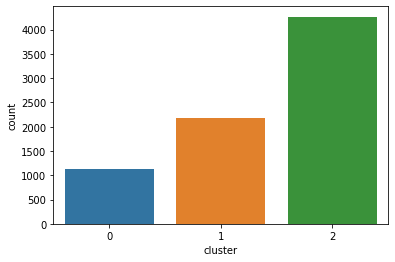

In [32]:
y = cluster.fit_predict(x_scaled)
player["cluster"] = y

sns.countplot(x= "cluster",data=player)
player["cluster"].value_counts()

#### data에서 Blue팀 Red팀 선수 별 클러스터링 결과 넣기  
#### 위해서 각각 원래 player 데이터 프레임에서 맞춰놓은
#### scaler로 스케일링

In [33]:
data_Blue = data[['B_avg_BODY_att', 'B_avg_CLINCH_att', 'B_avg_DISTANCE_att', 'B_avg_GROUND_att', 'B_avg_HEAD_att', 'B_avg_KD', 'B_avg_LEG_att',
       'B_avg_SIG_STR_att', 'B_avg_SUB_ATT', 'B_avg_TD_att', 'B_avg_TOTAL_STR_att', 'B_win_by_KO/TKO', 'B_win_by_Submission',
       ]]

In [34]:
data_Red = data[['R_avg_BODY_att', 'R_avg_CLINCH_att', 'R_avg_DISTANCE_att', 'R_avg_GROUND_att', 'R_avg_HEAD_att', 'R_avg_KD', 'R_avg_LEG_att',
       'R_avg_SIG_STR_att', 'R_avg_SUB_ATT', 'R_avg_TD_att', 'R_avg_TOTAL_STR_att', 'R_win_by_KO/TKO', 'R_win_by_Submission',
       ]]

In [35]:
data_B_scaled = scl.transform(data_Blue)
data_R_scaled = scl.transform(data_Red)

In [36]:
data_X["B_cluster"] = cluster.fit_predict(data_B_scaled)
data_X["R_cluster"] = cluster.fit_predict(data_R_scaled)

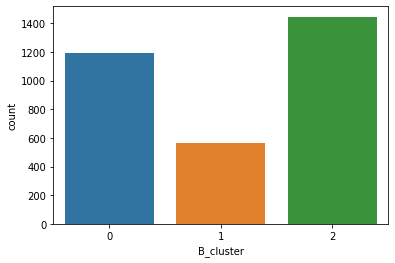

In [37]:
sns.countplot(x="B_cluster",data=data_X)

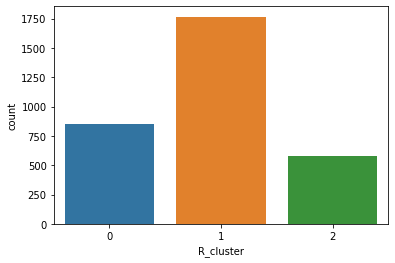

In [38]:
sns.countplot(x="R_cluster",data=data_X)

In [39]:
data_X.columns

Index(['B_avg_BODY_att', 'B_avg_CLINCH_att', 'B_avg_DISTANCE_att',
       'B_avg_GROUND_att', 'B_avg_HEAD_att', 'B_avg_KD', 'B_avg_LEG_att',
       'B_avg_SIG_STR_att', 'B_avg_SUB_ATT', 'B_avg_TD_att',
       'B_avg_TOTAL_STR_att', 'B_Height_cms', 'B_Reach_cms', 'B_Weight_lbs',
       'R_avg_BODY_att', 'R_avg_CLINCH_att', 'R_avg_DISTANCE_att',
       'R_avg_GROUND_att', 'R_avg_HEAD_att', 'R_avg_KD', 'R_avg_LEG_att',
       'R_avg_SIG_STR_att', 'R_avg_SUB_ATT', 'R_avg_TD_att',
       'R_avg_TOTAL_STR_att', 'R_Height_cms', 'R_Reach_cms', 'R_Weight_lbs',
       'title_bout', 'B_win_by_Decision_Majority', 'B_win_by_Decision_Split',
       'B_win_by_Decision_Unanimous', 'B_win_by_KO/TKO', 'B_win_by_Submission',
       'B_win_by_TKO_Doctor_Stoppage', 'R_win_by_Decision_Majority',
       'R_win_by_Decision_Split', 'R_win_by_Decision_Unanimous',
       'R_win_by_KO/TKO', 'R_win_by_Submission',
       'R_win_by_TKO_Doctor_Stoppage', 'B_current_lose_streak',
       'B_current_win_streak', 'B_win

In [40]:
B_scaled = pd.DataFrame(data_B_scaled)
R_scaled = pd.DataFrame(data_R_scaled)

In [41]:
col = ['B_avg_BODY_att', 'B_avg_CLINCH_att', 'B_avg_DISTANCE_att', 'B_avg_GROUND_att', 'B_avg_HEAD_att', 'B_avg_KD', 'B_avg_LEG_att',
       'B_avg_SIG_STR_att', 'B_avg_SUB_ATT', 'B_avg_TD_att', 'B_avg_TOTAL_STR_att', 'B_win_by_KO/TKO']
col2 = ['BODY','CLINCH','DISTANCE','GROUND','HEAD','KD','LEG','SIGSTR','SUB','TD','TOTALSTR','WIN(T)KO']
len(col2)
len(col)

12

12

In [42]:
a = pd.concat([B_scaled,data_X["B_cluster"]],axis=1)
a2 = pd.concat([R_scaled,data_X["R_cluster"]],axis=1)
a.head()
a2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,B_cluster
0,0.180392,0.002299,0.230996,0.027083,0.175451,0.160000,0.120635,0.218729,0.044444,0.032000,0.184444,0.181818,0.076923,2.0
1,0.286275,0.135632,0.460148,0.025000,0.404332,0.000000,0.195238,0.464548,0.077778,0.040000,0.440833,0.000000,0.000000,1.0
2,0.301075,0.077494,0.312701,0.057460,0.244206,0.129032,0.222222,0.324415,0.039427,0.086452,0.288082,0.909091,0.461538,2.0
3,0.333333,0.158046,0.404059,0.135417,0.419675,0.100000,0.047619,0.455686,0.027778,0.100000,0.429861,0.181818,0.000000,1.0
4,0.333333,0.028736,0.741697,0.000000,0.666065,0.000000,0.031746,0.680602,0.000000,0.000000,0.566667,0.000000,0.000000,1.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,R_cluster
0,0.429412,0.195402,0.276753,0.097917,0.267870,0.080,0.084127,0.339130,0.011111,0.212000,0.360833,0.181818,0.000000,0.0
1,0.235294,0.106732,0.325250,0.191964,0.305312,0.000,0.306122,0.387482,0.047619,0.205714,0.448810,0.000000,0.153846,0.0
2,0.271895,0.032950,0.428536,0.055556,0.349218,0.040,0.217989,0.415831,0.111111,0.037333,0.369444,0.272727,0.461538,0.0
3,0.357843,0.067529,0.386993,0.010417,0.290614,0.075,0.206349,0.373746,0.000000,0.090000,0.326042,0.090909,0.000000,0.0
4,0.151961,0.126437,0.187269,0.005208,0.183213,0.100,0.059524,0.208194,0.000000,0.020000,0.176389,0.181818,0.000000,1.0


#### 데이터가 0인경우에는  NaN 값이 발생하므로 0으로 바꿔준다

In [43]:
a[np.isnan(a)] = 0
a2[np.isnan(a2)]= 0

###  선수들 정보만 모아놓은 데이터(player)로 fitting한 cluster를 각 Red, Blue에 적용시켰고
### Red,Blue의 클러스터별 특징을 파악하기 위한 시각화
###  선수 개개인의 타격형,그라운드형,MMA형인지를 분류

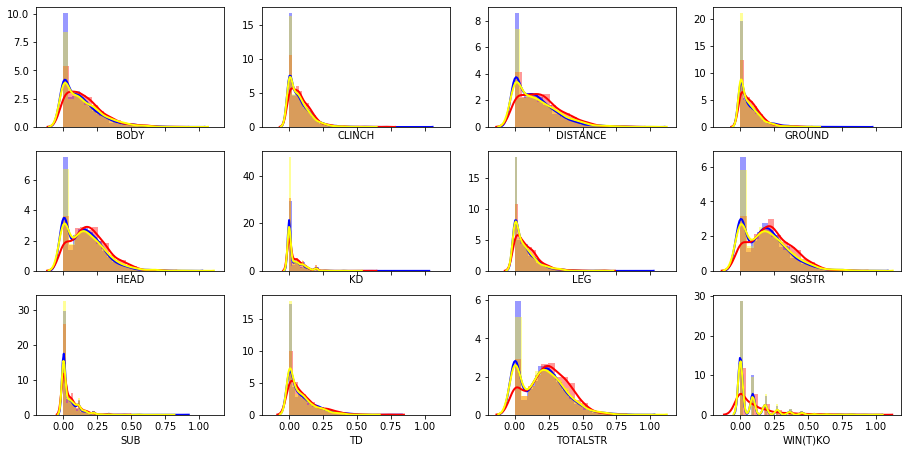

In [44]:
f, axes = plt.subplots(3, 4, figsize=(15.5, 7.5), sharex=True)
k = [0,1,2,3,4,5,6,7,8,9,10,11]
i = [0,0,0,0,1,1,1,1,2,2,2,2]

j = [0,1,2,3,0,1,2,3,0,1,2,3]
for k,i,j in zip(k,i,j):
    sns.distplot(a[a["B_cluster"]==0][a.columns[k]],  color="blue", axlabel=col2[k],norm_hist=True, kde_kws = {'linewidth': 2}, ax = axes[i, j])
    sns.distplot(a[a["B_cluster"]==1][a.columns[k]],  color="red", axlabel=col2[k],norm_hist=True, kde_kws = {'linewidth': 2}, ax = axes[i, j])
    sns.distplot(a[a["B_cluster"]==2][a.columns[k]],  color="yellow", axlabel=col2[k],norm_hist=True, kde_kws = {'linewidth': 2}, ax = axes[i, j])

In [45]:
col = ['R_avg_BODY_att', 'R_avg_CLINCH_att', 'R_avg_DISTANCE_att', 'R_avg_GROUND_att', 'R_avg_HEAD_att', 'R_avg_KD', 'R_avg_LEG_att',
       'R_avg_SIG_STR_att', 'R_avg_SUB_ATT', 'R_avg_TD_att', 'R_avg_TOTAL_STR_att', 'R_win_by_KO/TKO']
col2 = ['BODY','CLINCH','DISTANCE','GROUND','HEAD','KD','LEG','SIGSTR','SUB','TD','TOTALSTR','WIN(T)KO']
len(col2)
len(col)

12

12

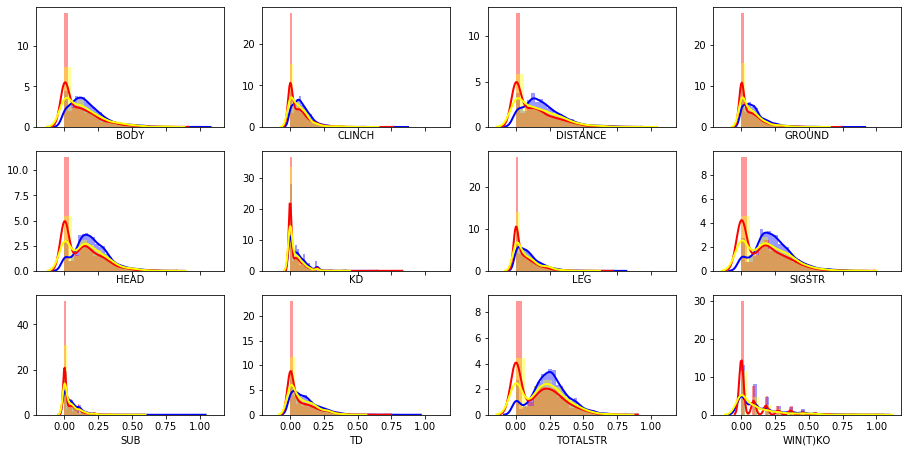

In [46]:
f, axes = plt.subplots(3, 4, figsize=(15.5, 7.5), sharex=True)
k = [0,1,2,3,4,5,6,7,8,9,10,11]
i = [0,0,0,0,1,1,1,1,2,2,2,2]

j = [0,1,2,3,0,1,2,3,0,1,2,3]
for k,i,j in zip(k,i,j):
    sns.distplot(a2[a2["R_cluster"]==0][a2.columns[k]],  color="blue", axlabel=col2[k],hist=True, kde_kws = {'linewidth': 2}, ax = axes[i, j])
    sns.distplot(a2[a2["R_cluster"]==1][a2.columns[k]],  color="red", axlabel=col2[k],hist=True, kde_kws = {'linewidth': 2}, ax = axes[i, j])
    sns.distplot(a2[a2["R_cluster"]==2][a2.columns[k]],  color="yellow", axlabel=col2[k],hist=True, kde_kws = {'linewidth': 2}, ax = axes[i, j])

### Feature Engineering (2) - PCA

###  Diminishing Dimension using Principal Component Analysis
#### 앞선 클러스터링 때 했던 방식처럼 Red , Blue 합친데이터인  player로 fitting한 후 
#### 원 데이터에서 Red, Blue 독립적으로 PCA(주성분 분석) 적용

#### data_X(모델링에 쓸 데이터)가 아닌 data(원 데이터)에서 컬럼들을 추출해온다.
#### 이유는 앞에서 data_X에 win_by column이 포함되어있지 않기 때문이다.

In [47]:
data.columns[65]
data.columns[71]
Bwin = data[data.columns[65:71]]
Bwin.head()

'B_win_by_Decision_Majority'

'B_wins'

,B_win_by_Decision_Majority,B_win_by_Decision_Split,B_win_by_Decision_Unanimous,B_win_by_KO/TKO,B_win_by_Submission,B_win_by_TKO_Doctor_Stoppage
0,0,1,0,2,1,0
1,0,2,1,0,0,1
2,0,0,7,10,6,0
3,0,0,2,2,0,0
4,0,0,1,0,0,0


In [48]:
data.columns[132]
data.columns[138]
Rwin = data[data.columns[132:138]]
Rwin.head()

'R_win_by_Decision_Majority'

'R_wins'

,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage
0,0,2,4,2,0,0
1,0,1,2,0,2,0
2,0,1,3,3,6,1
3,0,1,4,1,0,0
4,0,0,1,2,0,0


In [49]:
player.columns[57]
player.columns[63]
win = player[player.columns[57:63]] # win 컬럼 전까지 win_by만

'B_win_by_Decision_Majority'

'B_wins'

In [50]:
win.rename(columns = {win.columns[0] : "Majority",
                      win.columns[1] : "Split",
                      win.columns[2] : "Unanimous",
                      win.columns[3] : "KO/TKO",
                      win.columns[4] : "Submission",
                      win.columns[5] : "DoctorStop"}, inplace=True)
win.head()

,Majority,Split,Unanimous,KO/TKO,Submission,DoctorStop
0,0.0,1.0,0.0,2.0,1.0,0.0
1,0.0,2.0,1.0,0.0,0.0,1.0
2,0.0,0.0,7.0,10.0,6.0,0.0
3,0.0,0.0,2.0,2.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0


## Scatter Plot of Win_by Columns

In [51]:
sctwin = pd.concat([win,player["B_wins"]],axis=1)
sctwin.head()

,Majority,Split,Unanimous,KO/TKO,Submission,DoctorStop,B_wins
0,0.0,1.0,0.0,2.0,1.0,0.0,4.0
1,0.0,2.0,1.0,0.0,0.0,1.0,4.0
2,0.0,0.0,7.0,10.0,6.0,0.0,23.0
3,0.0,0.0,2.0,2.0,0.0,0.0,4.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0


Text(0.5, 1.0, 'TotalWin ~ Majority')

Text(0.5, 0, 'Majority')

Text(0, 0.5, 'TotalWin')

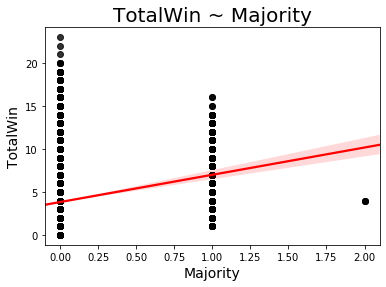

In [52]:
sns.regplot(x="Majority",  y="B_wins", data=sctwin,scatter_kws={"color": "black"}, line_kws={"color": "red"},fit_reg=True)
plt.title('TotalWin ~ Majority', fontsize=20)
plt.xlabel('Majority', fontsize=14)
plt.ylabel('TotalWin', fontsize=14)
plt.show()

Text(0.5, 1.0, 'TotalWin ~ Split')

Text(0.5, 0, 'Split')

Text(0, 0.5, 'TotalWin')

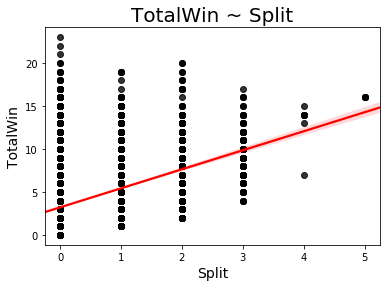

In [53]:
sns.regplot(x="Split",  y="B_wins", data= sctwin,scatter_kws={"color": "black"}, line_kws={"color": "red"},fit_reg=True)
plt.title('TotalWin ~ Split', fontsize=20)
plt.xlabel('Split', fontsize=14)
plt.ylabel('TotalWin', fontsize=14)
plt.show()

Text(0.5, 1.0, 'TotalWin ~ Unanimous')

Text(0.5, 0, 'Unanimous')

Text(0, 0.5, 'TotalWin')

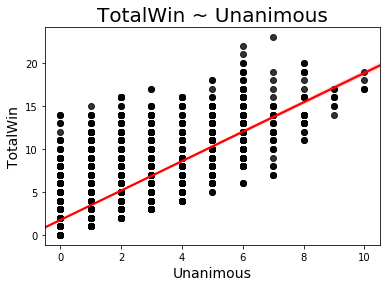

In [54]:
sns.regplot(x="Unanimous",  y="B_wins",data=sctwin,scatter_kws={"color": "black"}, line_kws={"color": "red"},fit_reg=True)
plt.title('TotalWin ~ Unanimous', fontsize=20)
plt.xlabel('Unanimous', fontsize=14)
plt.ylabel('TotalWin', fontsize=14)
plt.show()

Text(0.5, 1.0, 'TotalWin ~ KO/TKO ')

Text(0.5, 0, 'KO/TKO')

Text(0, 0.5, 'TotalWin')

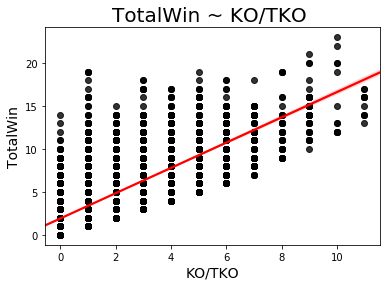

In [55]:
sns.regplot(x="KO/TKO",  y="B_wins",data=sctwin,scatter_kws={"color": "black"}, line_kws={"color": "red"},fit_reg=True)
plt.title('TotalWin ~ KO/TKO ', fontsize=20)
plt.xlabel('KO/TKO', fontsize=14)
plt.ylabel('TotalWin', fontsize=14)
plt.show()

Text(0.5, 1.0, 'TotalWin ~ Submission')

Text(0.5, 0, 'Split')

Text(0, 0.5, 'TotalWin')

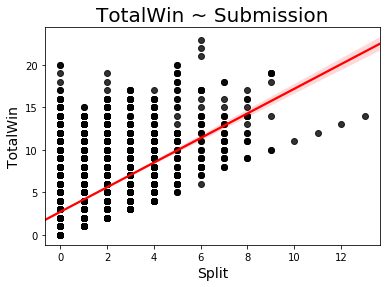

In [56]:
sns.regplot(x="Submission",  y="B_wins",data=sctwin, scatter_kws={"color": "black"}, line_kws={"color": "red"},fit_reg=True)
plt.title('TotalWin ~ Submission', fontsize=20)
plt.xlabel('Split', fontsize=14)
plt.ylabel('TotalWin', fontsize=14)
plt.show()

Text(0.5, 1.0, 'TotalWin ~ DoctorStop')

Text(0.5, 0, 'Split')

Text(0, 0.5, 'TotalWin')

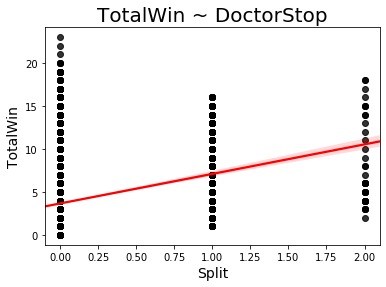

In [57]:
sns.regplot(x="DoctorStop",  y="B_wins",data=sctwin, scatter_kws={"color": "black"}, line_kws={"color": "red"},fit_reg=True)
plt.title('TotalWin ~ DoctorStop', fontsize=20)
plt.xlabel('Split', fontsize=14)
plt.ylabel('TotalWin', fontsize=14)
plt.show()

In [58]:
corrmat = sctwin.corr()
corrmat

,Majority,Split,Unanimous,KO/TKO,Submission,DoctorStop,B_wins
Majority,1.000000,0.049287,0.014331,0.163627,0.001327,0.036852,0.150856
Split,0.049287,1.000000,0.307400,0.126125,0.024449,0.028883,0.385890
Unanimous,0.014331,0.307400,1.000000,0.334489,0.218164,0.105946,0.750435
KO/TKO,0.163627,0.126125,0.334489,1.000000,0.116154,0.221089,0.742047
Submission,0.001327,0.024449,0.218164,0.116154,1.000000,0.073697,0.537324
DoctorStop,0.036852,0.028883,0.105946,0.221089,0.073697,1.000000,0.269935
B_wins,0.150856,0.385890,0.750435,0.742047,0.537324,0.269935,1.000000


### HeatMap of Correlation

<Figure size 1440x1440 with 0 Axes>

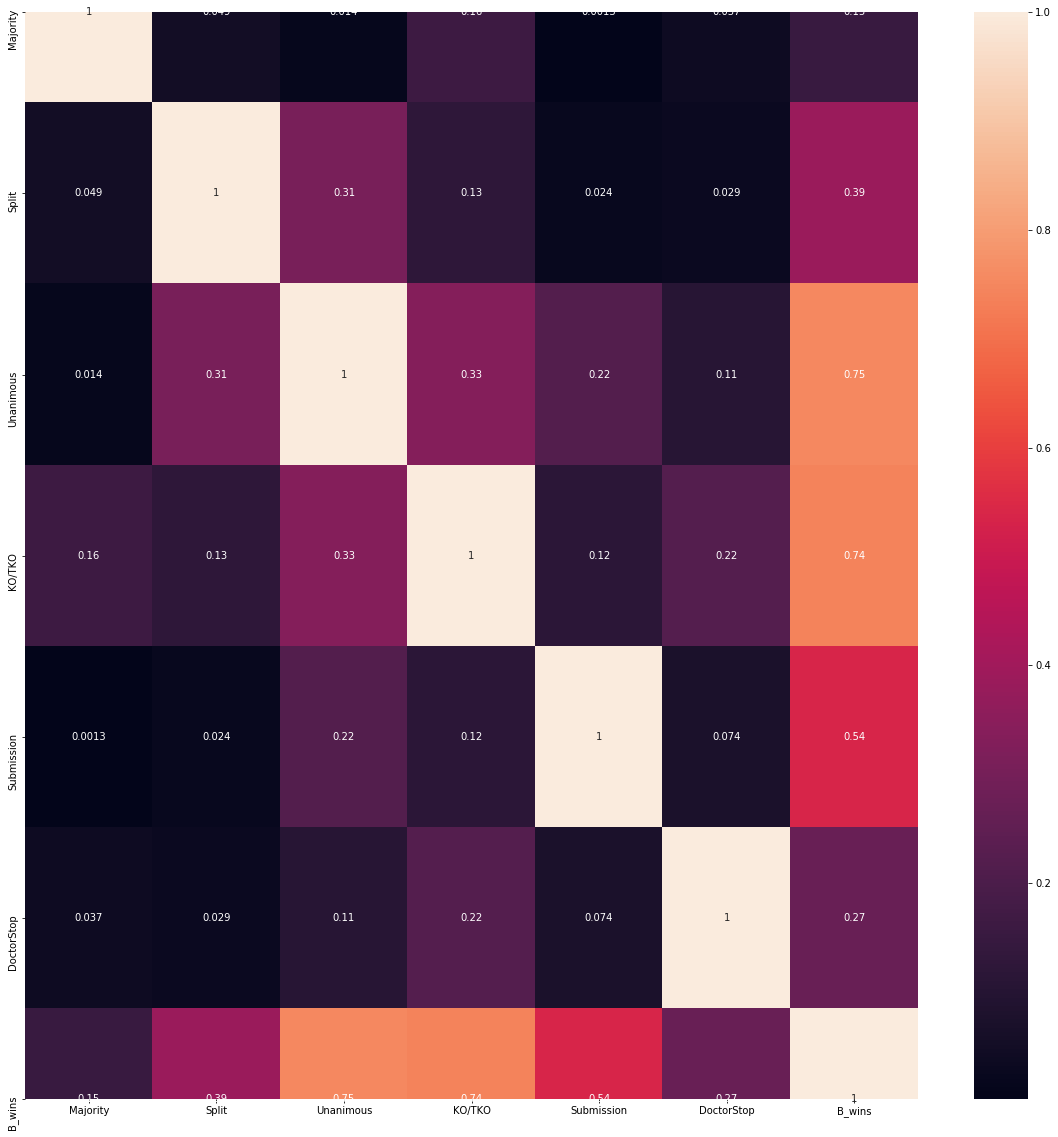

In [59]:
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
g=sns.heatmap(sctwin[top_corr_features].corr(),annot=True)

### Principal Component Analysis

In [60]:
from sklearn.decomposition import PCA
pca=PCA(n_components=3)
pca.fit(win)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [61]:
eigens_v=pca.components_.transpose()
print(eigens_v)

[[ 0.0106941  -0.01344795  0.00404312]
 [ 0.07893073  0.07104741 -0.10600876]
 [ 0.56092654  0.61670463 -0.53256068]
 [ 0.79571833 -0.58119119  0.1662985 ]
 [ 0.21188622  0.52586653  0.8230119 ]
 [ 0.03087986 -0.0113145   0.01100658]]


In [62]:
pca.explained_variance_ratio_
pca.explained_variance_

array([0.50387497, 0.24922148, 0.19069082])

array([4.05673368, 2.00650009, 1.53526555])

In [63]:
BPCscore=pca.transform(Bwin)
BPCscore[:,0]

array([-0.12777986, -1.2603656 , 11.14495291, ..., -1.21431513,
       -1.44910692,  0.37712152])

In [64]:
RPCscore=pca.transform(Rwin)
RPCscore[:,0]

array([ 1.98297081, -0.38547722,  3.44102905, ..., -0.38771694,
       -2.01003346, -1.00242892])

#### pca를 통한 결과를 data_X에 추가한다.

In [65]:
win.rename(columns = {win.columns[0] : "Majority",
                      win.columns[1] : "Split",
                      win.columns[2] : "Unanimous",
                      win.columns[3] : "KO/TKO",
                      win.columns[4] : "Submission",
                      win.columns[5] : "DoctorStop"}, inplace=True)
win.head()

,Majority,Split,Unanimous,KO/TKO,Submission,DoctorStop
0,0.0,1.0,0.0,2.0,1.0,0.0
1,0.0,2.0,1.0,0.0,0.0,1.0
2,0.0,0.0,7.0,10.0,6.0,0.0
3,0.0,0.0,2.0,2.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0


In [66]:
data_X["RPC1"] = RPCscore[:,0]
data_X["RPC2"] = RPCscore[:,1]
data_X["RPC3"] = RPCscore[:,2]
data_X["BPC1"] = BPCscore[:,0]
data_X["BPC2"] = BPCscore[:,1]
data_X["BPC3"] = BPCscore[:,2]

#### win_by 컬럼 삭제한다.

In [67]:
del data_X["B_win_by_Decision_Majority"]
del data_X["B_win_by_Decision_Unanimous"]
del data_X["B_win_by_Decision_Split"]
del data_X["B_win_by_KO/TKO"]
del data_X["B_win_by_Submission"]
del data_X["B_win_by_TKO_Doctor_Stoppage"]
del data_X["R_win_by_Decision_Majority"]
del data_X["R_win_by_Decision_Unanimous"]
del data_X["R_win_by_Decision_Split"]
del data_X["R_win_by_KO/TKO"]
del data_X["R_win_by_Submission"]
del data_X["R_win_by_TKO_Doctor_Stoppage"]

#### Winner가 draw(100)인 데이터 포인트 제거

In [68]:
data_X = data_X[data_X["Winner"] != 100]
data_X.head()

,B_avg_BODY_att,B_avg_CLINCH_att,B_avg_DISTANCE_att,B_avg_GROUND_att,B_avg_HEAD_att,B_avg_KD,B_avg_LEG_att,B_avg_SIG_STR_att,B_avg_SUB_ATT,B_avg_TD_att,...,R_Stance_Southpaw,R_Stance_Switch,B_cluster,R_cluster,RPC1,RPC2,RPC3,BPC1,BPC2,BPC3
0,9.200000,0.200000,62.600000,2.600000,48.600000,0.800000,7.6,65.40,0.400000,0.80000,...,0,0,2,0,1.982971,0.991611,-2.211891,-0.127780,-1.020388,0.847372
1,14.600000,11.800000,124.700000,2.400000,112.000000,0.000000,12.3,138.90,0.700000,1.00000,...,1,0,1,0,-0.385477,1.901270,0.272666,-1.260366,0.292565,-0.935799
2,15.354839,6.741935,84.741935,5.516129,67.645161,0.645161,14.0,97.00,0.354839,2.16129,...,0,0,2,0,3.441029,2.866553,3.542055,11.144953,1.205300,2.670904
3,17.000000,13.750000,109.500000,13.000000,116.250000,0.500000,3.0,136.25,0.250000,2.50000,...,0,0,1,0,1.108322,1.501755,-2.272181,0.703256,-0.383893,-0.934752
4,17.000000,2.500000,201.000000,0.000000,184.500000,0.000000,2.0,203.50,0.000000,0.00000,...,1,0,1,1,0.142330,-1.000598,-0.402191,-1.449107,0.161785,-0.734788


### Feature Engineering (3) -  categorization using finished time columns

#### win_by column들이 승리횟수와 강한 상관관계를 보이기에 3가지 종류로 분류해본다.
#### 판정승보다는 일찍끝내는 사람이 승률이 더 높을 것이라는 판단에서나온  아이디어
#### 실제로 예측성능에 많은 기여

#### E(arly) (TKO/KO, Submission, DoctorStop) - 경기라운드를 모두 채우지않는 즉, 일찍 끝내는 사람 
#### F(ull)      (Majority, Split , Unanimous) - 경기라운드를 모두 채우는 즉, 3(5)라운드가 끝난 뒤 판정승
#### N(othing)  두 경우의 비율이 같거나 혹은 첫경기인 사람

In [69]:
Bearly = data["B_win_by_KO/TKO"] + data["B_win_by_Submission"] + data["B_win_by_TKO_Doctor_Stoppage"]
Bfull = data["B_win_by_Decision_Majority"] + data["B_win_by_Decision_Split"]+data["B_win_by_Decision_Unanimous"]
data_X["Btime"] = Bearly / Bfull

#### 분모가 0인경우 Nan 발생 -> 0으로 대체

In [70]:
data_X[np.isnan(data_X["Btime"])]= 0

In [71]:
data_X["BFinish"] = np.where(data_X["Btime"]>1 ,"Early",np.where(data_X["Btime"]==0,"Normal","Full"))
OnlyE = Bfull == 0
data_X.loc[OnlyE,"BFinish"] = "Early"
OnlyF = Bearly == 0
data_X.loc[OnlyF,"BFinish"] = "Full"
ALL = data_X["B_wins"] ==0
data_X.loc[ALL,"BFinish"] = "Normal"

In [72]:
data_X[data_X.columns[11]]

0       167.64
1       167.64
2       185.42
3       170.18
4       180.34
         ...  
4887    182.88
4901    175.26
4923    180.34
4967    187.96
5008    182.88
Name: B_Height_cms, Length: 3151, dtype: float64

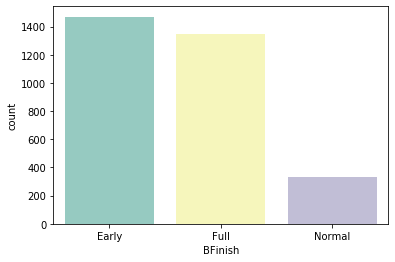

In [73]:
sns.countplot(x="BFinish",palette="Set3",data=data_X)

In [74]:
data_X["BFinish"].value_counts()

Early     1470
Full      1349
Normal     332
Name: BFinish, dtype: int64

In [75]:
data_X["BFinish"] = data_X["BFinish"].map({"Normal" : 0, "Early" :1,"Full":2})

In [76]:
Rearly = data["R_win_by_KO/TKO"] + data["R_win_by_Submission"] + data["R_win_by_TKO_Doctor_Stoppage"]
Rfull = data["R_win_by_Decision_Majority"] + data["R_win_by_Decision_Split"]+data["R_win_by_Decision_Unanimous"]
data_X["Rtime"] = Rearly / Rfull

In [77]:
data_X[np.isnan(data_X["Rtime"])] = 0

In [78]:
data_X["RFinish"] = np.where(data_X["Rtime"]>1 ,"Early",np.where(data_X["Rtime"]==0,"Normal","Full"))
OnlyE = Rfull == 0
data_X.loc[OnlyE,"RFinish"] = "Early"
OnlyF = Rearly == 0
data_X.loc[OnlyF,"RFinish"] = "Full"
ALL = data_X["R_wins"] ==0
data_X.loc[ALL,"RFinish"] = "Normal"

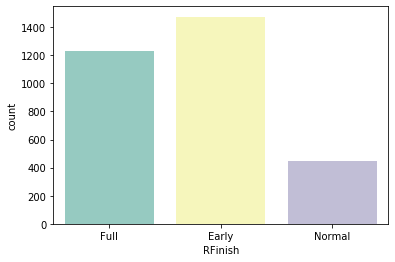

In [79]:
sns.countplot(x="RFinish",palette="Set3",data=data_X)

In [80]:
data_X["RFinish"].value_counts()

Early     1475
Full      1232
Normal     444
Name: RFinish, dtype: int64

#### 수치형으로 변환

In [81]:
data_X["RFinish"] = data_X["RFinish"].map({"Normal" : 0, "Early" :1,"Full":2})

In [82]:
del data_X["Btime"]
del data_X["Rtime"]

### StandardScaling

In [83]:
from sklearn.preprocessing import StandardScaler
scl = StandardScaler()

In [84]:
data_X.columns

Index(['B_avg_BODY_att', 'B_avg_CLINCH_att', 'B_avg_DISTANCE_att',
       'B_avg_GROUND_att', 'B_avg_HEAD_att', 'B_avg_KD', 'B_avg_LEG_att',
       'B_avg_SIG_STR_att', 'B_avg_SUB_ATT', 'B_avg_TD_att',
       'B_avg_TOTAL_STR_att', 'B_Height_cms', 'B_Reach_cms', 'B_Weight_lbs',
       'R_avg_BODY_att', 'R_avg_CLINCH_att', 'R_avg_DISTANCE_att',
       'R_avg_GROUND_att', 'R_avg_HEAD_att', 'R_avg_KD', 'R_avg_LEG_att',
       'R_avg_SIG_STR_att', 'R_avg_SUB_ATT', 'R_avg_TD_att',
       'R_avg_TOTAL_STR_att', 'R_Height_cms', 'R_Reach_cms', 'R_Weight_lbs',
       'title_bout', 'B_current_lose_streak', 'B_current_win_streak', 'B_wins',
       'R_current_lose_streak', 'R_current_win_streak', 'R_wins', 'B_age',
       'R_age', 'Winner', 'weight_class_Bantamweight',
       'weight_class_Catch Weight', 'weight_class_Featherweight',
       'weight_class_Flyweight', 'weight_class_Heavyweight',
       'weight_class_Light Heavyweight', 'weight_class_Lightweight',
       'weight_class_Middleweight', 

#### (더미변수, 나이, 신체조건, PCscore) 변수들을 제외한 나머지 스케일링

### 연속형의 경우 변수마다 값의 차이가 크므로 스케일링이 필요

In [85]:
data_X[data_X.columns[0:11]] = scl.fit_transform(data_X[data_X.columns[0:11]])
data_X[data_X.columns[14:25]] = scl.fit_transform(data_X[data_X.columns[14:25]])
data_X[data_X.columns[29:35]] = scl.fit_transform(data_X[data_X.columns[29:35]])

### Split Train and Test set

In [86]:
data_X.head()

,B_avg_BODY_att,B_avg_CLINCH_att,B_avg_DISTANCE_att,B_avg_GROUND_att,B_avg_HEAD_att,B_avg_KD,B_avg_LEG_att,B_avg_SIG_STR_att,B_avg_SUB_ATT,B_avg_TD_att,...,B_cluster,R_cluster,RPC1,RPC2,RPC3,BPC1,BPC2,BPC3,BFinish,RFinish
0,0.179996,-0.998895,0.345242,-0.664329,-0.061231,1.800322,0.367526,0.024314,-0.129077,-0.670291,...,2,0,1.982971,0.991611,-2.211891,-0.127780,-1.020388,0.847372,1,2
1,0.942575,0.586500,1.866017,-0.687737,1.642192,-0.775025,1.183364,1.630075,0.337581,-0.594777,...,1,0,-0.385477,1.901270,0.272666,-1.260366,0.292565,-0.935799,2,2
2,1.049172,-0.104796,0.887479,-0.323028,0.450472,1.301868,1.478454,0.714682,-0.199327,-0.156311,...,2,0,3.441029,2.866553,3.542055,11.144953,1.205300,2.670904,1,1
3,1.281499,0.853010,1.493782,0.552879,1.756381,0.834567,-0.430953,1.572180,-0.362406,-0.028426,...,1,0,1.108322,1.501755,-2.272181,0.703256,-0.383893,-0.934752,2,2
4,1.281499,-0.684549,3.734537,-0.968632,3.590113,-0.775025,-0.604535,3.041397,-0.751288,-0.972345,...,1,1,0.142330,-1.000598,-0.402191,-1.449107,0.161785,-0.734788,2,1


In [87]:
X = data_X[data_X.columns.difference(["Winner"])]
y = data_X["Winner"]

In [88]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 97)

In [89]:
X_train.shape , X_test.shape, y_train.shape, y_test.shape

((2205, 68), (946, 68), (2205,), (946,))

### RandomForest Model

In [90]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=500,random_state= 97)

In [91]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=97, verbose=0,
                       warm_start=False)

## Using GridSearch

In [ ]:
gs.best_params
nestimatro 300 ,max_depth = 10
gs.best_model

In [92]:
y_train_hat = rf.predict(X_train)
y_test_hat = rf.predict(X_test)

In [93]:
from sklearn.metrics import confusion_matrix , accuracy_score
training_accuracy = accuracy_score(y_train, y_train_hat)
testing_accuracy = accuracy_score(y_test, y_test_hat)
print(training_accuracy, testing_accuracy)

1.0 0.7230443974630021


#### win_by columns들을 pca로 차원축소

# Logistic model

In [94]:
from sklearn.linear_model import LogisticRegression

In [95]:
clf = LogisticRegression(C=1)

In [96]:
clf.fit(X_train,y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [97]:
y_train_hat = clf.predict(X_train)
y_test_hat = clf.predict(X_test)

In [98]:
training_accuracy = accuracy_score(y_train, y_train_hat)
testing_accuracy = accuracy_score(y_test, y_test_hat)

In [99]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_test_hat)
print(confusion_matrix)
print(training_accuracy, testing_accuracy)

[[230 194]
 [ 67 455]]
0.727437641723356 0.7241014799154334


# Adaboost

In [100]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=500, random_state=97)

In [101]:
clf.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=500, random_state=97)

In [102]:
y_train_hat_clf = clf.predict(X_train)
y_test_hat_clf = clf.predict(X_test)

In [103]:
training_accuracy_clf = accuracy_score(y_train,y_train_hat_clf)
testing_accuracy_clf = accuracy_score(y_test,y_test_hat_clf)
print(training_accuracy_clf, testing_accuracy_clf)

0.8662131519274376 0.6627906976744186
